## Intro to Domino Project

This notebook is based on the tutorial in the Domino Getting Started [docs](https://docs.dominodatalab.com/en/latest/user_guide/9a69d9/get-started-with-python/).

See [this document](https://www.bmreports.com/bmrs/?q=generation/fueltype/current) for information on the data and column headers.

In [1]:
#import the packages we need
%matplotlib inline
import pandas as pd
import datetime

In [2]:
#read in a new dataset if needed
#today = datetime.datetime.today().strftime('%Y-%m-%d')
#start_date = '2022-01-01'
#!curl -o data.csv "https://www.bmreports.com/bmrs/?q=ajax/filter_csv_download/FUELHH/csv/FromDate%3D{start_date}%26ToDate%3D{today}/" 2>/dev/null

In [3]:
#read in our data
df = pd.read_csv('data.csv', skiprows=1, skipfooter=1, header=None, engine='python')

In [4]:
#rename the columns
df = df.iloc[:,0:18]
df.columns = ['HDF', 'date', 'half_hour_increment',
              'CCGT', 'OIL', 'COAL', 'NUCLEAR',
              'WIND', 'PS', 'NPSHYD', 'OCGT',
              'OTHER', 'INTFR', 'INTIRL', 'INTNED',
               'INTEW', 'BIOMASS', 'INTEM']

#look at our data frame
df.head()

,HDF,date,half_hour_increment,CCGT,OIL,COAL,NUCLEAR,WIND,PS,NPSHYD,OCGT,OTHER,INTFR,INTIRL,INTNED,INTEW,BIOMASS,INTEM
0,FUELHH,20220101,1,2844,0,0,6799,10332,0,286,0,70,0,320,584,388,1536,0
1,FUELHH,20220101,2,2953,0,0,6800,10628,0,283,0,149,0,320,584,402,1553,0
2,FUELHH,20220101,3,2879,0,0,6808,11139,0,260,0,144,0,320,568,440,1528,0
3,FUELHH,20220101,4,2691,0,0,6804,11049,0,268,0,144,0,320,418,388,1521,0
4,FUELHH,20220101,5,3449,0,0,6796,11307,0,248,1,88,0,320,0,476,1602,0


In [5]:
#Create a new column datetime that represents the starting datetime of the measured increment
df['datetime'] = pd.to_datetime(df['date'], format="%Y%m%d")
df['datetime'] = df.apply(lambda x:x['datetime']+ datetime.timedelta(minutes=30*(int(x['half_hour_increment'])-1)), 
                          axis = 1)

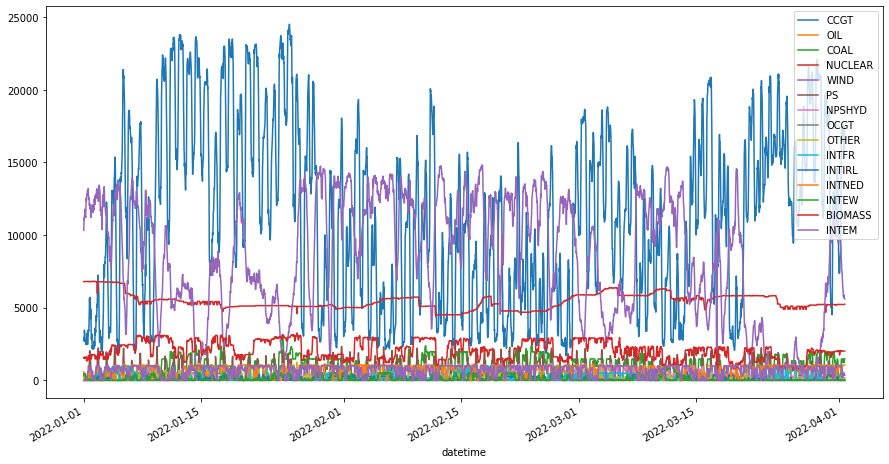

In [6]:
#Visualize the data to see how each fuel type is used during the day by plotting the data
df.drop(['HDF', 'date', 'half_hour_increment'], axis = 1).set_index('datetime').plot(figsize=(15,8));

### Train our model
The CCGT column representing “combined-cycle gas turbines” seems to be the most interesting. It generates a lot of energy and is very volatile.

We will concentrate on this column and try to predict the power generation from this fuel source.

In [7]:
#Prep our data - for Facebook Prophet, the time series data needs to be in a DataFrame with 2 columns named ds and y
df_for_prophet = df[['datetime', 'CCGT']].rename(columns = {'datetime':'ds', 'CCGT':'y'})

In [8]:
#Split the dataset into train and test sets
X = df_for_prophet.copy()
y = df_for_prophet['y']

proportion_in_training = 0.8
split_index = int(proportion_in_training*len(y))

X_train, y_train = X.iloc[:split_index], y.iloc[:split_index]
X_test, y_test = X.iloc[split_index:], y.iloc[split_index:]

In [9]:
#install Facebook Prophet. Note that this install will not persist beyond this session
#can be skipped if the compute environment you are using already has these packages
!pip install -q --user "convertdate==2.1.2" "holidays==0.10.3" "lunarcalendar==0.0.9" "pystan==2.19.1.1"
!pip install -q --user "fbprophet==0.7.1"

In [10]:
#import Facebook Prophet and fit a model
from fbprophet import Prophet
from dateutil.easter import easter

m = Prophet(yearly_seasonality=False)
m.fit(X_train);

Initial log joint probability = -194.555
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5132.05      0.108837       558.204           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165        5169.9   0.000463487        156.27   4.044e-06       0.001      233  LS failed, Hessian reset 
     199       5188.35     0.0031364       106.069      0.3425      0.3425      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       5193.42   0.000307463       108.544   3.061e-06       0.001      349  LS failed, Hessian reset 
     299       5205.68     0.0141144       194.121     0.05764           1      434   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     390       5212.37   0.000497811       98.5146   1.474e-06       0.001      584  LS failed, Hessian rese

In [11]:
#Make a DataFrame to hold the predictions and predict future values of CCGT power generation

future = m.make_future_dataframe(periods=int(len(y_test)/2), freq='H')
forecast = m.predict(future)

#inspect the dataframe
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3911,2022-04-01 11:00:00,10665.103678,3140.911326,18778.367590
3912,2022-04-01 12:00:00,10323.262104,2409.833261,18301.827675
3913,2022-04-01 13:00:00,10283.594210,2967.683176,17923.056209
3914,2022-04-01 14:00:00,10538.525166,2276.667550,18705.987368
3915,2022-04-01 15:00:00,11048.497359,2940.690974,19054.101980


<Figure size 432x288 with 0 Axes>

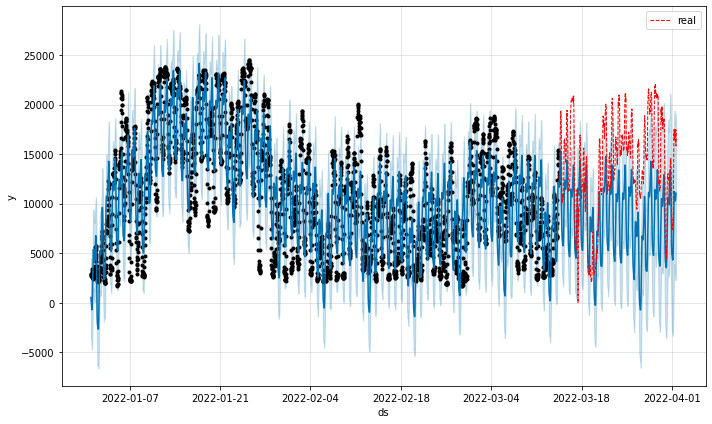

In [12]:
#Plot the fitted line with the training and test data
import matplotlib.pyplot as plt

plt.gcf();
fig = m.plot(forecast);
plt.plot(X_test['ds'].dt.to_pydatetime(), X_test['y'], 'r', linewidth = 1, linestyle = '--', label = 'real');
plt.legend();

### Export trained model
Trained models are meant to be used. There is no reason to re-train the model each time you use the model. Export or serialize the model to a file to load and reuse the model later. In Python, the pickle module implements protocols for serializing and de-serializing objects.

In [13]:
#export the trained model as a pickle file for later use
import pickle
#m.stan_backend.logger = None    #uncomment if using Python 3.6 and fbprophet==0.6
with open("model.pkl", "wb") as f:
      pickle.dump(m, f)

### Save a training set for monitoring purposes
Optionally, you can save the data used to train this model as a "training set".
This will enable integrated monitoring of the model once published as a Model API.
See our [docs](https://docs.dominodatalab.com/en/latest/api_guide/9c4dec/create-trainingsets/) for a full example of saving a training set.

In [15]:
from domino.training_sets import TrainingSetClient, model

# Time series models are not actually suitable for monitoring feature drift,
#  so this is a somewhat artificial example where we use the target column
#  itself as a dummy feature column and monitor only the target column for drift.
df_for_training_set = df_for_prophet.copy()
df_for_training_set['dummy_y'] = df_for_training_set['y']
df_for_training_set.drop(['ds'], axis = 1, inplace=True)
training_set_version = TrainingSetClient.create_training_set_version(
    training_set_name='melanie_forecast_power',
    df=df_for_training_set,
    target_columns=['y'],
)